In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.fft import fft, fftfreq, fftshift, fft2 
from scipy.integrate import solve_ivp

plt.rcParams.update({'font.size':14, 'savefig.facecolor':'w'})

Для колебаний в кристаллической одномерной решетке атомов существует модель из классических осцилляторов. Каждый атом может колебаться около своего положения $n a$, где $n-$номер атома и $a-$размер атомной ячейки. Каждый атом связан с соседним пружиной с жесткостью $K$. 

## Атомы одинаковых масс
**Уравнения и описание системы взяты из лекции "Фононы в кристаллах. Акустические и оптические колебания" Хохлова Д.Р.** [https://teach-in.ru/lecture/10_17_Khokhlov#00:31:31]()

Сила, действующая на атом в цепочке, $f_n = K (\xi_{n+1} - \xi_n) - K (\xi_n - \xi_{n-1})$, где $\xi_n-$ отклонение атома с номером $n$ от равновесного положения в кристалле. 

Тогда уравнения движения
\begin{equation}
	m\ddot \xi = K (\xi_{n+1} + \xi_{n-1} - 2\xi_n)
\end{equation} 

Решением является плоская волна $\xi_n=\xi_0\exp^{i(\omega t+ n a k)}$, тогда частота $\omega$ связана с волновым числом $k$:
\begin{equation}\label{eq:solutionequal}
	\omega = \pm 2 \sqrt{\frac{K}{m}\sin\left(\frac{k a}{2}\right)}
\end{equation}
Максимум частоты $\omega_{max}= 2\sqrt{\left(\frac{K}{m}\right)}$. Максимальное значение модуля $|k|=\frac{\pi}{a}$, так как длина волны не может быть меньше $2a$.

## Атомы двух масс
**Уравнения и описание системы взяты из книги *Левитов Л., Шитов А. Функции Грина. Задачи и решения. – Litres, 2022.*** 
Пусть атомы будут двух видов: с массой $m$ и массой $M > m$.

Гамильтониан системы:
\begin{equation}
	\mathcal{H} = \Sigma_{i=-\infty}^{\infty}\left[p_i^2/(2m_i) + (K/2)(x_i-x_{i+1})^2\right]
\end{equation}
где $m_i=m$, если $i$ четное, $m_i=M$ если $i$ нечетное. 

Пусть $x_i-$смещение атома массы $m$ в $i-$й элементарной ячейке,   $y_i-$смещение атома массы $M$ в $i-$й элементарной ячейке. Тогда уравнения движения определяются формулами:
\begin{eqnarray}
	m \ddot x_i = K(y_i + y_{i-1} -2x_i) \\
	M\ddot y_i = K(x_i + x_{i+1} - 2y_i)
\end{eqnarray}

Закон дисперсии (связь волнового вектора $k$ и частоты колебаний $\omega$) 
\begin{equation}\label{eq:solutionalt}
	\omega^2_{\pm}(k) = \frac{K}{\mu}\left(1\pm\sqrt{1 - \frac{4\mu^2}{mM}\sin^2(k/2)}\right)
\end{equation} 
где $\mu = Mm/(M+m)$. Знак $+$ соответствует оптической моде и $-$ акустической. 



# Моделирование системы с частицами разных масс

Частицы имеют разные радиусы и одинаковую плотность. Зная $\omega_{max}$, можно вычислить жесткость пружины $K$. Это выражение получается из $\omega^2_{\pm}(k) = \frac{K}{\mu}\left(1\pm\sqrt{1 - \frac{4\mu^2}{mM}\sin^2(k/2)}\right)$, $\omega$ достигает максимума при $k = 0$, $\omega^2_{+}(k) = \frac{K}{\mu}(1 + 1)$ отсюда $K = \omega_{max} ^ 2 \mu / 2$.

Параметры моделирования $a=1, \omega_{max}=2\cdot 10^{-4}, m=\pi 10^2, M = \pi 11^2$. 

In [2]:
a = 1

rad, rad2 = 10, 11

m, M = np.pi * rad ** 2, np.pi * rad2 ** 2
mu = M * m / (M + m)

K = 3
print(f'K = {K}')
print(f'm = {m}')
print(f'M = {M}')
print(f'a = {a}')

K = 3
m = 314.1592653589793
M = 380.132711084365
a = 1


## График аналитического решения

max frequency =  0.1867687191940803


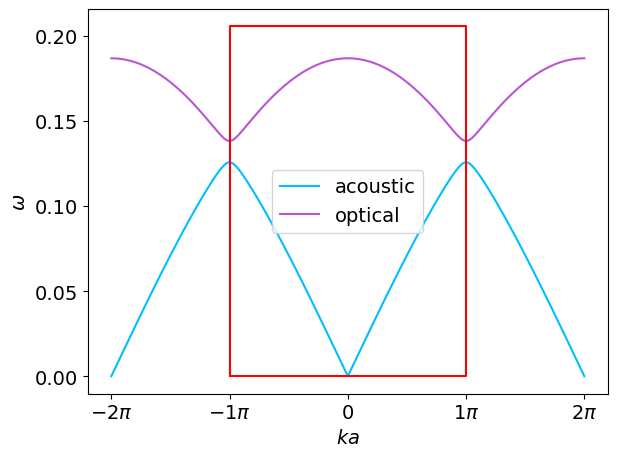

In [12]:
fig, ax = plt.subplots()

q = np.linspace(- 2 * np.pi, 2 * np.pi, 1000)

w2 = K / mu * (1 - (1 - 4 * mu ** 2 / m / M * np.sin(q / 2) ** 2) ** 0.5)
plt.plot(q, w2 ** 0.5, color='deepskyblue', label='acoustic')

w2 = K / mu * (1 + (1 - 4 * mu ** 2 / m / M * np.sin(q / 2) ** 2) ** 0.5)
plt.plot(q, w2 ** 0.5, color='mediumorchid', label='optical')
max_freq_analytical = (2 * K / mu) ** 0.5
print('max frequency = ', max_freq_analytical)

x0, y0 = [-np.pi, 0]
x1, y1 = [np.pi, w2.max() ** 0.5 * 1.1]

plt.plot([x0, x1, x1, x0, x0], [y0, y0, y1, y1, y0], 'r')

k = np.arange(-2, 3, 1)
x_ticks = k * np.pi
x_labels = [f'${int(x)}\pi$' if x !=0 else str(0) for x in k]

ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels)

ax.set_xlabel('$k a$')
ax.set_ylabel('$\omega$')

plt.legend()

fig.tight_layout()

## Численное интегрирование уравнений

In [4]:
def eq_spring(t, xy, K):  
    x = xy[::4]
    y = xy[1::4]
    vx = xy[2::4]
    vy = xy[3::4]
    
    dvx = K / m * (y + np.roll(y, 1) - 2 * x)
    dvy = K / M * (x + np.roll(x, -1) - 2 * y)
    
    dxy = np.array([vx, vy, dvx, dvy]).T.reshape(-1,)
    
    return dxy
    

In [5]:
N = 80 # количество частиц в цепочке
amp = 0.1 # начальное смещение равномерно распределено в [-amp / 2, amp / 2]
x = np.random.rand(N // 2) * amp - amp / 2
y = np.random.rand(N // 2) / 10 - amp / 2

vx, vy = np.zeros(N // 2), np.zeros(N // 2) # начальные скорости равны 0

xydxdy = np.vstack([x, y, vx, vy])
xydxdy = xydxdy.T.reshape(-1,)

In [6]:
step = 1e-2
time_span = [0, 4000]

t_eval = np.arange(time_span[0], time_span[1], step)

sol = solve_ivp(eq_spring, time_span, xydxdy, 
                args=(K,),
                method='RK45', first_step=step, max_step=step,
                rtol=1e-12, atol=1e-12)

In [7]:
sol.y.shape, sol.t.shape

((160, 400001), (400001,))

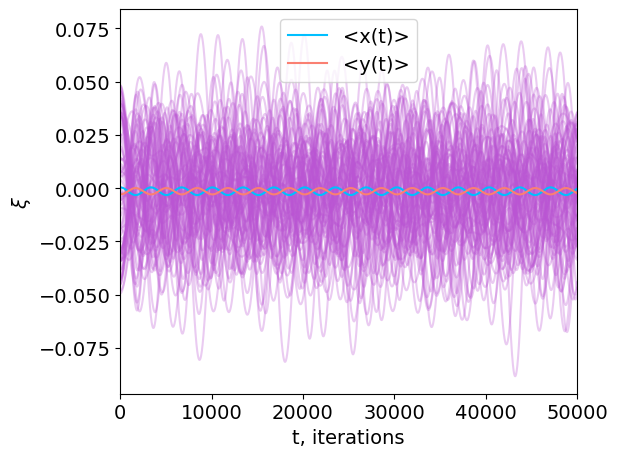

In [8]:
fig, ax = plt.subplots()
xlim = 50000
for x in sol.y[::4]:
    ax.plot(x[:xlim], color='mediumorchid', alpha=0.3)
    
for y in sol.y[1::4]:
    ax.plot(y[:xlim], color='mediumorchid', alpha=0.3)

ax.plot(sol.y[::4].mean(axis=0), color='deepskyblue', label='<x(t)>')
ax.plot(sol.y[1::4].mean(axis=0), color='salmon', label='<y(t)>')

ax.set_xlabel('t, iterations')
ax.set_ylabel(r'$\xi$')

ax.set_xlim([0, xlim])
plt.legend(loc='upper center')

fig.tight_layout()

fig.savefig('pics/oscillations_ode.png', dpi=300)
fig.savefig('pics/oscillations_ode.pdf')

In [9]:
txy = np.zeros((N, sol.t.size, 2))
for i in range(N):
    txy[i, :, 0] = sol.t
    
for i in range(N // 2):
    txy[2 * i, :, 1] = sol.y[i * 4]
    txy[2 * i + 1, :, 1] = sol.y[i * 4 +1]
    
txy.shape

(80, 400001, 2)

### Частота колебаний нечетных частиц
Средняя частота колебаний по нечетным (или по четным) частицам совпадает с максимальной частотой колебаний, с максимумом частоты оптических колебаний.

Частота колебаний рассчитывается с помощью одномерного преобразования Фурье и сравнивается с аналитическим значением максимума частоты.

0.18692429557785376
analytical  0.1867687191940803
0.00015557638377344807


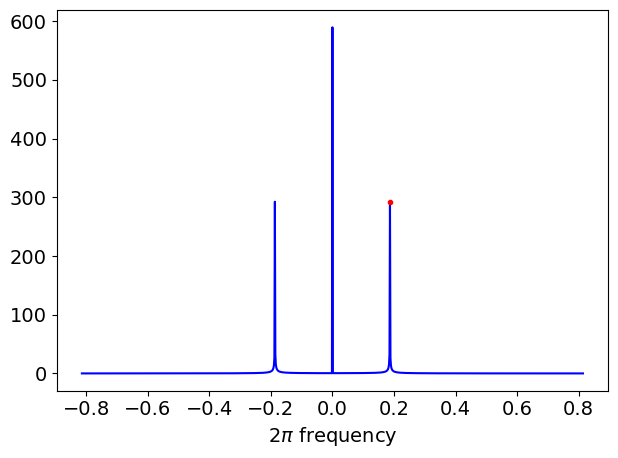

In [21]:
mean_odd = txy[1::2, :, 1].mean(axis=0)

a = fft(mean_odd)
freq = fftfreq(mean_odd.shape[0], d=step)
freq = fftshift(freq)

a = np.abs(fftshift(a))
# иногда максимум соответствует частоте 0, которая неинтересна
# чтобы исключить 0, максимум ищется в правой половине спектра
ind_max = mean_odd.shape[0] // 2 + 1 + np.argmax(a[mean_odd.shape[0] // 2 + 1:])
max_freq = np.abs(freq[ind_max] * 2 * np.pi)

pad = 400

fig, ax = plt.subplots()

ax.plot(2 * np.pi * freq[-(ind_max + pad): ind_max + pad],
        a[-(ind_max + pad): ind_max + pad], 'b')
ax.plot(2 * np.pi * freq[ind_max], a[ind_max], '.r')

ax.set_xlabel('$2\pi$ frequency')

fig.tight_layout()

fig.savefig('pics/fourier.png', dpi=300)
fig.savefig('pics/fourier.pdf', dpi=300)

print(max_freq )
print('analytical ', max_freq_analytical)
print(f'{max_freq - max_freq_analytical}')

In [14]:
out = fft2(txy[:, :, 1])

out = np.log(np.abs(out) ** 2 / N ** 2)

out2 = np.hstack((out[:, :140], out[:, -140:]))

out2[0, 0] = np.nan
out2[:, 0] = np.nan

s1 = out2.shape[0] / 2
s2 = out2.shape[1] // 2

# fftshift
out2 = np.roll(out2, shift=int(s1), axis=0)
out2 = np.roll(out2, shift=s2, axis=1)

In [15]:
# восстановленное из максимальной частоты значение жесткости почти совпадает с исходным значением K
max_freq ** 2 * mu / 2

3.0050000186709904

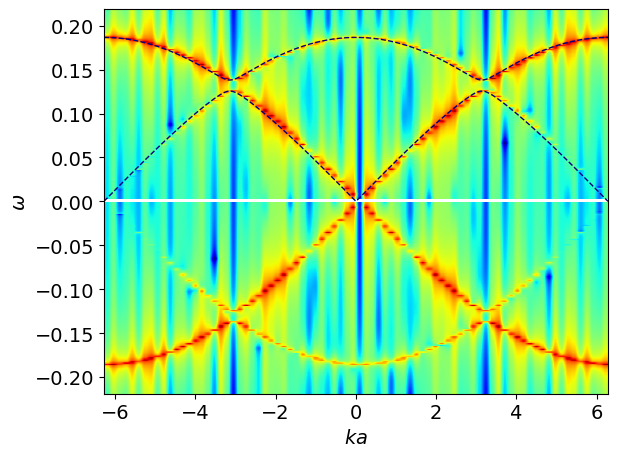

In [16]:
clim = None 
fig, ax = plt.subplots()
plt.imshow(out2.T, clim=clim, origin='lower', 
           aspect='auto', cmap='jet', 
           extent=(-2 * np.pi, 
                   2 * np.pi, 
                   -2 * np.pi * (s2 - 0.5) / time_span[1] ,
                   2 * np.pi * (s2 - 0.5) / time_span[1]))

q = np.linspace(- 2 * np.pi, 2 * np.pi, 1000)
w2 = K / mu * (1 - (1 - 4 * mu ** 2 / m / M * np.sin(q / 2) ** 2) ** 0.5)
plt.plot(q, w2 ** 0.5, label='acoustic', color='navy', linestyle='--', linewidth=1)
w2 = K / mu * (1 + (1 - 4 * mu ** 2 / m / M * np.sin(q / 2) ** 2) ** 0.5)
plt.plot(q, w2 ** 0.5, color='navy', label='optical', linestyle='--', linewidth=1)

ax.set_xlim([-2 * np.pi, 2 * np.pi])

# x_ticks = np.arange(-2, 3, 1) * np.pi
# x_labels = [f'${int(x)}\pi$' if x !=0 else str(0) for x in x_ticks]

# ax.set_xticks(x_ticks)
# ax.set_xticklabels(x_labels)

ax.set_xlabel('$k a$')
ax.set_ylabel('$\omega$')

fig.tight_layout()
fig.savefig('pics/spectrum_oscillations_ode.png', dpi=300)
fig.savefig('pics/spectrum_oscillations_ode.pdf')

### Спектр для нечетных частиц

In [17]:
out = fft2(txy[1::2, :, 1])
N = out.shape[0]
out = np.log(np.abs(out) ** 2 / N ** 2)

out2 = np.hstack((out[:,:140], out[:,-140:]))
# if num_particles >= 4:
#     out2[0] = np.nan
out2[0,0] = np.nan
out2[:,0] = np.nan
s1 = out2.shape[0]/2
s2 = out2.shape[1]//2



out2 = np.roll(out2, shift=int(s1), axis=0)
out2 = np.roll(out2, shift=s2, axis=1)

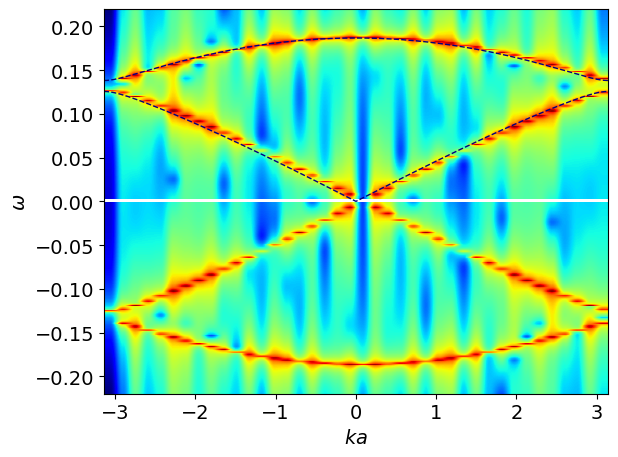

In [18]:
clim = None 

fig, ax = plt.subplots()
plt.imshow(out2.T, clim=clim, origin='lower', 
           aspect='auto', cmap='jet', 
           extent=(-2 * np.pi * s1 / N, 
                   2 * np.pi * s1 / N, 
                   -2 * np.pi * s2 / time_span[1],
                   2 * np.pi * s2 / time_span[1]))

q = np.linspace(- np.pi, np.pi, 1000)
w2 = K / mu * (1 - (1 - 4 * mu ** 2 / m / M * np.sin(q / 2) ** 2) ** 0.5)
plt.plot(q, w2 ** 0.5, label='acoustic', color='navy', linestyle='--', linewidth=1)
w2 = K / mu * (1 + (1 - 4 * mu ** 2 / m / M * np.sin(q / 2) ** 2) ** 0.5)
plt.plot(q, w2 ** 0.5, label='optical', color='navy', linestyle='--', linewidth=1)

ax.set_xlim([-np.pi, np.pi])

ax.set_xlabel('$k a$')
ax.set_ylabel('$\omega$')

fig.tight_layout()
fig.savefig('pics/odd_spectrum_oscillations_ode.png', dpi=300)
fig.savefig('pics/odd_spectrum_oscillations_ode.pdf')